In [4]:
from dateutil.parser import parse
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, ComplementNB

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 定义真实账户的CSV文件路径
PATH_GENUINE_ACCOUNTS_USERS = r"E:\edge下载\cresci-2017.csv\data\genuine_accounts.csv\genuine_accounts.csv\genuine_users.csv"
PATH_GENUINE_ACCOUNTS_TWEETS = r"E:\edge下载\cresci-2017.csv\data\genuine_accounts.csv\genuine_accounts.csv\genuine_tweets.csv"

# 定义垃圾邮件机器人账户的CSV文件路径
PATH_SPAM_BOTS_USERS = r"E:\edge下载\cresci-2017.csv\data\social_spambots_1.csv\social_spambots_1.csv\social_users.csv"
PATH_SPAM_BOTS_TWEETS = r"E:\edge下载\cresci-2017.csv\data\social_spambots_1.csv\social_spambots_1.csv\social_tweets.csv"


def load_data():
    """
    加载真实账户和垃圾邮件机器人账户的用户数据及推文数据
    :return: 分别返回真实账户用户数据框、真实账户推文数据框、垃圾邮件机器人账户用户数据框、垃圾邮件机器人账户推文数据框
    """
    df_genuine_users = pd.read_csv(PATH_GENUINE_ACCOUNTS_USERS, encoding='utf-8')
    df_genuine_tweets = pd.read_csv(PATH_GENUINE_ACCOUNTS_TWEETS, encoding='utf-8')
    df_spam_bots_users = pd.read_csv(PATH_SPAM_BOTS_USERS, encoding='utf-8')
    df_spam_bots_tweets = pd.read_csv(PATH_SPAM_BOTS_TWEETS, encoding='utf-8')

    return df_genuine_users, df_genuine_tweets, df_spam_bots_users, df_spam_bots_tweets


def preprocess_data(df_genuine_users, df_genuine_tweets, df_spam_bots_users, df_spam_bots_tweets):
    """
    对数据进行预处理操作，包括删除列、遍历列打印值、合并数据等
    :param df_genuine_users: 真实账户用户数据框
    :param df_genuine_tweets: 真实账户推文数据框
    :param df_spam_bots_users: 垃圾邮件机器人账户用户数据框
    :param df_spam_bots_tweets: 垃圾邮件机器人账户推文数据框
    :return: 返回合并后的用户数据框和推文数据框
    """
    # 从df_genuine_users数据框中删除名为test_set_1和test_set_2的两列数据
    df_genuine_users.drop(columns=['test_set_1', 'test_set_2'], inplace=True)

    # 遍历df_spam_bots_tweets数据框的每一列，并打印出df_genuine_tweets数据框中第一行（索引为0）对应列的值
    for column in df_spam_bots_tweets.columns:
        print(column + ": " + str(df_genuine_tweets.loc[0, column]))

    # 将两个不同类型账户对应的用户数据和推文数据分别进行合并操作

    x_df = pd.concat([df_genuine_users, df_spambots_users])
    tweets_df = pd.concat([df_genuine_tweets, df_spambots_tweets])

    return x_df, tweets_df


def convert_timestamp(ts):
    """
    将输入的时间戳相关的字符串ts转换为一个数值形式的时间戳
    :param ts: 输入的时间戳字符串
    :return: 转换后的数值形式时间戳
    """
    try:
        return parse(ts).timestamp()
    except:
        return int(ts[:-1]) / 1000


def calculate_intertime(df):
    """
    计算给定数据框中推文时间戳的间隔时间总和的平均值
    :param df: 包含推文数据的DataFrame
    :return: 平均间隔时间
    """
    tweet_timestamps = []
    for index, row in df.iterrows():
        tweet_timestamps.append(convert_timestamp(str(row["created_at"])))

    tweet_timestamps.sort()
    tts_diff = np.diff(np.array(tweet_timestamps))
    return sum(tts_diff) / (len(tts_diff) if len(tts_diff)!= 0 else 1)


def extract_features(x_df, tweets_df):
    """
    基于已有的用户数据框和推文数据框，为每个用户计算一系列特征值
    :param x_df: 合并后的用户数据框
    :param tweets_df: 合并后的推文数据框
    :return: 包含所有用户特征向量的列表
    """
    x_vector = []
    for index, row in x_df.iterrows():
        # 当前用户的id
        usr_id = row['id']
        usr_tweets_df = tweets_df.loc[tweets_df["user_id"] == usr_id]
        tweet_count = len(usr_tweets_df) if len(usr_tweets_df)!= 0 else 1

        # 计算特征
        retweets_ratio = len(usr_tweets_df[usr_tweets_df.retweeted_status_id!= 0]) / tweet_count
        replies_ratio = len(usr_tweets_df[usr_tweets_df.in_reply_to_status_id!= 0]) / tweet_count
        favoriteC_per_tweet = row["favourites_count"] / tweet_count
        hashtag_avg = sum(usr_tweets_df["num_hashtags"].values.tolist()) / tweet_count
        url_avg = sum(usr_tweets_df["num_urls"].values.tolist()) / tweet_count
        mentions_avg = sum(usr_tweets_df["num_mentions"].values.tolist()) / tweet_count
        intertime = calculate_intertime(usr_tweets_df)


        
        ffratio = row["friends_count"] / (row["followers_count"] if row["followers_count"]!= 0 else 1)
        # favorites_count = row["favourites_count"]
        # listed_count = row["listed_count"]
        uniqueHashtags = -1
        uniqueMentions = -1
        uniqueURL = -1

        # usr_features = [retweets_ratio, replies_ratio, favoriteC_per_tweet, hashtag_avg, url_avg, mentions_avg,
                        # intertime, ffratio, favorites_count, listed_count]
        usr_features = [retweets_ratio, replies_ratio, favoriteC_per_tweet, hashtag_avg, url_avg, mentions_avg,
                        intertime, ffratio]
        x_vector.append(usr_features)

    return x_vector


def normalize_data(x_vector):
    """
    对x_vector中的数据进行归一化处理
    :param x_vector: 包含用户特征向量的列表
    :return: 归一化后的DataFrame
    """
    x = preprocessing.normalize(x_vector)
    # df = pd.DataFrame(x, columns=['retweets', 'replies', 'favoriteC', 'hashtag', 'url', 'mentions', 'intertime',
    #                               'ffratio', 'favorites', 'listed'])
    df = pd.DataFrame(x, columns=['retweets', 'replies', 'favoriteC', 'hashtag', 'url', 'mentions', 'intertime',
                                  'ffratio'])
    return df


def create_labels(df_genuine_users, df_spam_bots_users):
    """
    创建一个用于标记数据类别的标签列表y，根据数据来源设定标签值
    :param df_genuine_users: 真实账户用户数据框
    :param df_spam_bots_users: 垃圾邮件机器人账户用户数据框
    :return: 标签列表y
    """
    y = np.zeros(len(df_genuine_users), dtype=int).tolist() + np.ones(len(df_spam_bots_users), dtype=int).tolist()
    return y


if __name__ == "__main__":
    # 加载数据
    df_genuine_users, df_genuine_tweets, df_spam_bots_users, df_spam_bots_tweets = load_data()

    # 预处理数据
    x_df, tweets_df = preprocess_data(df_genuine_users, df_genuine_tweets, df_spam_bots_users, df_spam_bots_tweets)

    # 提取特征
    x_vector = extract_features(x_df, tweets_df)

    # 归一化数据
    df = normalize_data(x_vector)

    # 创建标签
    y = create_labels(df_genuine_users, df_spam_bots_users)

    # 对特征数据和对应的标签数据进行随机打乱操作
    x, y = shuffle(df.values, y)
    x_train, x_test, y_train, y_test = train_test_split(x, y)

C:\Users\HP\AppData\Local\Temp\ipykernel_48120\499658087.py:36: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_genuine_tweets = pd.read_csv(PATH_GENUINE_ACCOUNTS_TWEETS, encoding='utf-8')
C:\Users\HP\AppData\Local\Temp\ipykernel_48120\499658087.py:38: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_spam_bots_tweets = pd.read_csv(PATH_SPAM_BOTS_TWEETS, encoding='utf-8')


id: 593932392663912449
text: RT @morningJewshow: Speaking about Jews and comedy tonight at Temple Emanu-El in San Francisco. In other words, my High Holidays.
source: <a href="http://tapbots.com/tweetbot" rel="nofollow">Tweetbot for iΟS</a>
user_id: 678033.0
truncated: nan
in_reply_to_status_id: 0.0
in_reply_to_user_id: 0.0
in_reply_to_screen_name: nan
retweeted_status_id: 5.939321685245338e+17
geo: nan
place: nan
contributors: nan
retweet_count: 1.0
reply_count: 0.0
favorite_count: 0.0
favorited: nan
retweeted: nan
possibly_sensitive: nan
num_hashtags: 0.0
num_urls: 0.0
num_mentions: 1.0
created_at: Fri May 01 00:18:11 +0000 2015
timestamp: 2015-05-01 02:18:11
crawled_at: 2015-05-01 12:57:19
updated: 2015-05-01 12:57:19


In [28]:
def train_and_evaluate_svc(x_train, y_train, x_test, y_test, kernel_type):
    """
    使用指定核函数的支持向量机（SVC）算法构建分类器，进行训练、预测并评估性能
    :param x_train: 训练数据特征
    :param y_train: 训练数据标签
    :param x_test: 测试数据特征
    :param y_test: 测试数据标签
    :param kernel_type: SVC的核函数类型，如'linear'或'poly'
    :return: 包含ROC曲线数据和AUC值的结果列表
    """
    svc_classifier = SVC(kernel=kernel_type, probability=True)
    svc_classifier.fit(x_train, y_train)

    y_pred = svc_classifier.predict(x_test)
    print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

    fpr, tpr, _ = roc_curve(y_test, svc_classifier.predict_proba(x_test)[:,1])
    auc = roc_auc_score(y_test, svc_classifier.predict_proba(x_test)[:,1])
    return [fpr, tpr, f" SVM {kernel_type.capitalize()} Kernel, AUC={auc:.3f}"]


def train_and_evaluate_random_forest(x_train, y_train, x_test, y_test):
    """
    使用随机森林分类器进行训练、预测并评估性能
    :param x_train: 训练数据特征
    :param y_train: 训练数据标签
    :param x_test: 测试数据特征
    :param y_test: 测试数 据标签
    :return: 包含ROC曲线数据和AUC值的结果列表
    """
    rfc_model = RandomForestClassifier()
    rfc_model.fit(x_train, y_train)

    y_pred = rfc_model.predict(x_test)
    print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))
    print(confusion_matrix(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

    fpr, tpr, _ = roc_curve(y_test, rfc_model.predict_proba(x_test)[:,1])
    auc = roc_auc_score(y_test, rfc_model.predict_proba(x_test)[:,1])
    return [fpr, tpr, "RFC, AUC={:.3f}".format(auc)]


def train_and_evaluate_logistic_regression(x_train, y_train, x_test, y_test):
    """
    使用逻辑回归分类器进行训练、预测并评估性能
    :param x_train: 训练数据特征
    :param y_train: 训练数据标签
    :param x_test: 测试数据特征
    :param y_test: 测试数据标签
    :return: 包含ROC曲线数据和AUC值的结果列表
    """
    logreg_model = LogisticRegression()
    logreg_model.fit(x_train, y_train)

    y_pred = logreg_model.predict(x_test)
    print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']) )
    print(confusion_matrix(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

    fpr, tpr, _ = roc_curve(y_test, logreg_model.predict_proba(x_test)[:,1])
    auc = roc_auc_score(y_test, logreg_model.predict_proba(x_test)[:,1])
    return [fpr, tpr, "Log Regression, AUC={:.3f}".format(auc)]


def train_and_evaluate_gaussian_nb(x_train, y_train, x_test, y_test):
    """
    使用高斯朴素贝叶斯分类器进行训练、预测并评估性能
    :param x_train: 训练数据特征
    :param y_train: 训练数据标签
    :param x_test: 测试数据特征
    :param y_test: 测试数据标签
    :return: 包含ROC曲线数据和AUC值的结果列表
    """
    n_bayes = GaussianNB()
    n_bayes.fit(x_train, y_train)

    expected = y_test
    predicted = n_bayes.predict(x_test)
    print(classification_report(expected, predicted, target_names=['Human', 'Bot']))
    print(confusion_matrix(expected, predicted))

    tn, fp, fn, tp = confusion_matrix(expected, predicted).ravel()
    print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

    fpr, tpr, _ = roc_curve(y_test, n_bayes.predict_proba(x_test)[:,1])
    auc = roc_auc_score(y_test, n_bayes.predict_proba(x_test)[:,1])
    return [fpr, tpr, "Gaussian NB, AUC={:.3f}".format(auc)]


def train_and_evaluate_complement_nb(x_train, y_train, x_test, y_test):
    """
    使用互补朴素贝叶斯分类器进行训练、预测并评估性能
    :param x_train: 训练数据特征
    :param y_train: 训练数据标签
    :param x_test, y_test: 测试数据特征和标签
    :return: 包含ROC曲线数据和AUC值的结果列表
    """
    cn_bayes = ComplementNB()
    cn_bayes.fit(x_train, y_train)

    y_pred = cn_bayes.predict(x_test)
    print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))
    print(confusion_matrix(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

    fpr, tpr, _ = roc_curve(y_test, cn_bayes.predict_proba(x_test)[:,1])
    auc = roc_auc_score(y_test, cn_bayes.predict_proba(x_test)[:,1])
    return [fpr, tpr, "Complement NB, AUC={:.3f}".format(auc)]


def train_and_evaluate_neural_network(x_train, y_train, x_test, y_test, batch_size, epochs):
    """
    使用神经网络进行训练、预测并评估性能
    :param x_train: 训练数据特征
    :param y_train: 训练数据标签
    :param x_test: 测试数据特征
    :param y_test: 测试数据标签
    :param batch_size: 训练批次大小
    :param epochs: 训练轮数
    :return: 包含ROC曲线数据和AUC值的结果列表
    """
    model = tf.keras.Sequential([
        layers.Dense(10),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dropout(.1),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(np.array(x_train),
              np.array(y_train),
              batch_size=batch_size,
              epochs=epochs)

    loss, accuracy = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
    print("Accuracy: ", accuracy)

    # y_pred = np.argmax(model.predict(x_test), axis=-1)

    y_pred = (model.predict(x_test)>0.5).astype('int32')
    print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))
    print(confusion_matrix(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp})")

    fpr, tpr, _ = roc_curve(y_test, model.predict(x_test).ravel())
    auc = roc_auc_score(y_test, model.predict(x_test).ravel())
    return [fpr, tpr, "Neural Network, AUC={:.3f}".format(auc)]

E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       Human       0.78      1.00      0.88       873
         Bot       0.00      0.00      0.00       244

    accuracy                           0.78      1117
   macro avg       0.39      0.50      0.44      1117
weighted avg       0.61      0.78      0.69      1117

True Negatives: 873, False Positives: 0, False Negatives: 244, True Positives: 0


E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       Human       0.78      1.00      0.88       873
         Bot       0.00      0.00      0.00       244

    accuracy                           0.78      1117
   macro avg       0.39      0.50      0.44      1117
weighted avg       0.61      0.78      0.69      1117

True Negatives: 873, False Positives: 0, False Negatives: 244, True Positives: 0
              precision    recall  f1-score   support

       Human       0.99      1.00      0.99       873
         Bot       1.00      0.96      0.98       244

    accuracy                           0.99      1117
   macro avg       0.99      0.98      0.99      1117
weighted avg       0.99      0.99      0.99      1117

[[873   0]
 [ 10 234]]
True Negatives: 873, False Positives: 0, False Negatives: 10, True Positives: 234
              precision    recall  f1-score   support

       Human       0.78      1.00      0.88       873
         Bot       0.00      0.00      0.00       2

E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\keras\src\backend\tensorflow\nn.py:750: UserWarni

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7342 - loss: 0.4772
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7617 - loss: 0.3318
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7730 - loss: 0.3286
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7767 - loss: 0.3239
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7719 - loss: 0.3223
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7624 - loss: 0.3302
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7737 - loss: 0.3316
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7831 - loss: 0.3284
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7602 - loss: 0.3276
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7697 - loss: 0.3268
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7788 - loss: 0.3185
Epoch 12/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


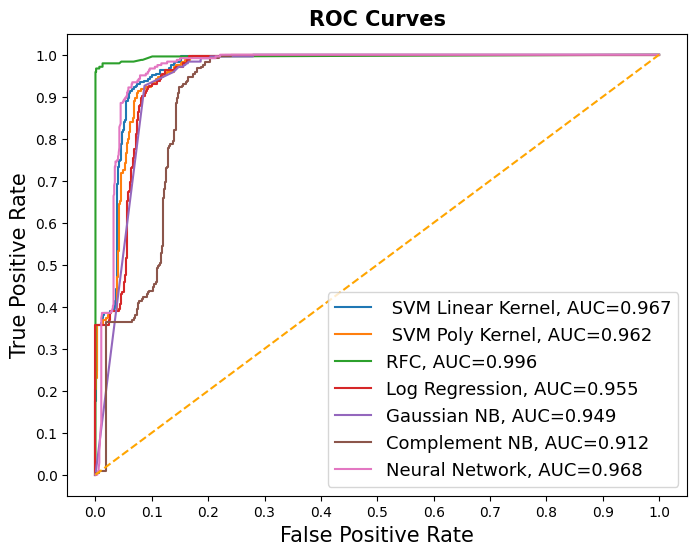

In [29]:
results = []
# 训练并评估线性核函数的SVC模型
results.append(train_and_evaluate_svc(x_train, y_train, x_test, y_test, 'linear'))

# 训练并评估多项式核函数的SVC模型
results.append(train_and_evaluate_svc(x_train, y_train, x_test, y_test, 'poly'))

# 训练并评估随机森林模型
results.append(train_and_evaluate_random_forest(x_train, y_train, x_test, y_test))
# 训练并评估逻辑回归模型
results.append(train_and_evaluate_logistic_regression(x_train, y_train, x_test, y_test))

# 训练并评估高斯朴素贝叶斯模型
results.append(train_and_evaluate_gaussian_nb(x_train, y_train, x_test, y_test))

# 训练并评估互补朴素贝叶斯模型
results.append(train_and_evaluate_complement_nb(x_train, y_train, x_test, y_test))

# 定义神经网络训练参数
batch_size = 32
epochs = 20

# 训练并评估神经网络模型
results.append(train_and_evaluate_neural_network(x_train, y_train, x_test, y_test, batch_size, epochs))

# 绘制ROC曲线
fig = plt.figure(figsize=(8, 6))

for result in results:
    plt.plot(result[0], result[1], label=result[2])

plt.plot([0, 1], [0, 1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curves', fontweight='bold', fontsize=15)
plt.legend(prop={'size': 13}, loc='lower right')

plt.show()

————————————————————————————

In [8]:
def train_and_evaluate_svc(x_train, y_train, x_test, y_test, kernel_type):
    """
    使用指定核函数的支持向量机（SVC）算法构建分类器，进行训练、预测并评估性能
    :param x_train: 训练数据特征
    :param y_train: 训练数据标签
    :param x_test: 测试数据特征
    :param y_test: 测试数据标签
    :param kernel_type: SVC的核函数类型，如'linear'或'poly'
    :return: 包含ROC曲线数据和AUC值的结果列表，以及训练好的模型
    """
    svc_classifier = SVC(kernel=kernel_type, probability=True)
    svc_classifier.fit(x_train, y_train)

    y_pred = svc_classifier.predict(x_test)
    print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

    fpr, tpr, _ = roc_curve(y_test, svc_classifier.predict_proba(x_test)[:, 1])
    auc = roc_auc_score(y_test, svc_classifier.predict_proba(x_test)[:, 1])
    return [fpr, tpr, f" SVM {kernel_type.capitalize()} Kernel, AUC={auc:.3f}"], svc_classifier

In [9]:
def train_and_evaluate_random_forest(x_train, y_train, x_test, y_test):
    """
    使用随机森林分类器进行训练、预测并评估性能
    :param x_train: 训练数据特征
    :param y_train: 训练数据标签
    :param x_test: 测试数据特征
    :param y_test: 测试数据标签
    :return: 包含ROC曲线数据和AUC值的结果列表，以及训练好的模型
    """
    rfc_model = RandomForestClassifier()
    rfc_model.fit(x_train, y_train)

    y_pred = rfc_model.predict(x_test)
    print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))
    print(confusion_matrix(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

    fpr, tpr, _ = roc_curve(y_test, rfc_model.predict_proba(x_test)[:, 1])
    auc = roc_auc_score(y_test, rfc_model.predict_proba(x_test)[:, 1])
    return [fpr, tpr, "RFC, AUC={:.3f}".format(auc)], rfc_model

In [10]:
def train_and_evaluate_logistic_regression(x_train, y_train, x_test, y_test):
    """
    使用逻辑回归分类器进行训练、预测并评估性能
    :param x_train: 训练数据特征
    :param y_train: 训练数据标签
    :param x_test: 测试数据特征
    :param y_test: 测试数据标签
    :return: 包含ROC曲线数据和AUC值的结果列表，以及训练好的模型
    """
    logreg_model = LogisticRegression()
    logreg_model.fit(x_train, y_train)

    y_pred = logreg_model.predict(x_test)
    print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))
    print(confusion_matrix(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

    fpr, tpr, _ = roc_curve(y_test, logreg_model.predict_proba(x_test)[:, 1])
    auc = roc_auc_score(y_test, logreg_model.predict_proba(x_test)[:, 1])
    return [fpr, tpr, "Log Regression, AUC={:.3f}".format(auc)], logreg_model

In [11]:
def train_and_evaluate_gaussian_nb(x_train, y_train, x_test, y_test):
    """
    使用高斯朴素贝叶斯分类器进行训练、预测并评估性能
    :param x_train: 训练数据特征
    :param y_train: 训练数据标签
    :param x_test: 测试数据特征
    :param y_test: 测试数据标签
    :return: 包含ROC曲线数据和AUC值的结果列表，以及训练好的模型
    """
    n_bayes = GaussianNB()
    n_bayes.fit(x_train, y_train)

    expected = y_test
    predicted = n_bayes.predict(x_test)
    print(classification_report(expected, predicted, target_names=['Human', 'Bot']))
    print(confusion_matrix(expected, predicted))

    tn, fp, fn, tp = confusion_matrix(expected, predicted).ravel()
    print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

    fpr, tpr, _ = roc_curve(y_test, n_bayes.predict_proba(x_test)[:, 1])
    auc = roc_auc_score(y_test, n_bayes.predict_proba(x_test)[:, 1])
    return [fpr, tpr, "Gaussian NB, AUC={:.3f}".format(auc)], n_bayes

In [12]:
def train_and_evaluate_complement_nb(x_train, y_train, x_test, y_test):
    """
    使用互补朴素贝叶斯分类器进行训练、预测并评估性能
    :param x_train: 训练数据特征
    :param y_train: 训练数据标签
    :param x_test: 测试数据特征
    :param y_test: 测试数据标签
    :return: 包含ROC曲线数据和AUC值的结果列表，以及训练好的模型
    """
    cn_bayes = ComplementNB()
    cn_bayes.fit(x_train, y_train)

    y_pred = cn_bayes.predict(x_test)
    print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))
    print(confusion_matrix(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

    fpr, tpr, _ = roc_curve(y_test, cn_bayes.predict_proba(x_test)[:, 1])
    auc = roc_auc_score(y_test, cn_bayes.predict_proba(x_test)[:, 1])
    return [fpr, tpr, "Complement NB, AUC={:.3f}".format(auc)], cn_bayes

In [13]:
def train_and_evaluate_neural_network(x_train, y_train, x_test, y_test, batch_size, epochs):
    """
    使用神经网络进行训练、预测并评估性能
    :param x_train: 训练数据特征
    :param y_train: 训练数据标签
    :param x_test: 测试数据特征
    :param y_test: 测试数据标签
    :param batch_size: 训练批次大小
    :param epochs: 训练轮数
    :return: 包含ROC曲线数据和AUC值的结果列表，以及训练好的模型
    """
    model = tf.keras.Sequential([
        layers.Dense(10),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dropout(.1),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(np.array(x_train),
              np.array(y_train),
              batch_size=batch_size,
              epochs=epochs)

    loss, accuracy = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
    print("Accuracy: ", accuracy)

    y_pred = (model.predict(x_test) > 0.5).astype(int)
    print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))
    print(confusion_matrix(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

    fpr, tpr, _ = roc_curve(y_test, model.predict(x_test).ravel())
    auc = roc_auc_score(y_test, model.predict(x_test).ravel())
    return [fpr, tpr, "Neural Network, AUC={:.3f}".format(auc)], model

In [17]:
results = []
models = {}

In [18]:
svc_linear_result, svc_linear = train_and_evaluate_svc(x_train, y_train, x_test, y_test, 'linear')
results.append(svc_linear_result)
models['svc_linear'] = svc_linear

              precision    recall  f1-score   support

       Human       0.78      1.00      0.88       873
         Bot       0.00      0.00      0.00       244

    accuracy                           0.78      1117
   macro avg       0.39      0.50      0.44      1117
weighted avg       0.61      0.78      0.69      1117

True Negatives: 873, False Positives: 0, False Negatives: 244, True Positives: 0


E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
# 训练并评估多项式核函数的SVC模型
svc_poly_result, svc_poly = train_and_evaluate_svc(x_train, y_train, x_test, y_test, 'poly')
results.append(svc_poly_result)
models['svc_poly'] = svc_poly  # 保存模型

              precision    recall  f1-score   support

       Human       0.78      1.00      0.88       873
         Bot       0.00      0.00      0.00       244

    accuracy                           0.78      1117
   macro avg       0.39      0.50      0.44      1117
weighted avg       0.61      0.78      0.69      1117

True Negatives: 873, False Positives: 0, False Negatives: 244, True Positives: 0


E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
# 训练并评估随机森林模型
rfc_result, rfc_model = train_and_evaluate_random_forest(x_train, y_train, x_test, y_test)
results.append(rfc_result)
models['random_forest'] = rfc_model 

              precision    recall  f1-score   support

       Human       0.99      1.00      0.99       873
         Bot       1.00      0.96      0.98       244

    accuracy                           0.99      1117
   macro avg       0.99      0.98      0.99      1117
weighted avg       0.99      0.99      0.99      1117

[[873   0]
 [ 10 234]]
True Negatives: 873, False Positives: 0, False Negatives: 10, True Positives: 234


In [21]:
# 训练并评估逻辑回归模型
logreg_result, logreg_model = train_and_evaluate_logistic_regression(x_train, y_train, x_test, y_test)
results.append(logreg_result)
models['logistic_regression'] = logreg_model

              precision    recall  f1-score   support

       Human       0.78      1.00      0.88       873
         Bot       0.00      0.00      0.00       244

    accuracy                           0.78      1117
   macro avg       0.39      0.50      0.44      1117
weighted avg       0.61      0.78      0.69      1117

[[873   0]
 [244   0]]
True Negatives: 873, False Positives: 0, False Negatives: 244, True Positives: 0


E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# 训练并评估高斯朴素贝叶斯模型
gnb_result, n_bayes = train_and_evaluate_gaussian_nb(x_train, y_train, x_test, y_test)
results.append(gnb_result)
models['gaussian_nb'] = n_bayes  # 保存模型

              precision    recall  f1-score   support

       Human       1.00      0.76      0.87       873
         Bot       0.54      1.00      0.70       244

    accuracy                           0.81      1117
   macro avg       0.77      0.88      0.78      1117
weighted avg       0.90      0.81      0.83      1117

[[667 206]
 [  1 243]]
True Negatives: 667, False Positives: 206, False Negatives: 1, True Positives: 243


In [23]:
# 训练并评估互补朴素贝叶斯模型
cnb_result, cn_bayes = train_and_evaluate_complement_nb(x_train, y_train, x_test, y_test)
results.append(cnb_result)
models['complement_nb'] = cn_bayes  # 保存模型

              precision    recall  f1-score   support

       Human       1.00      0.69      0.82       873
         Bot       0.48      1.00      0.64       244

    accuracy                           0.76      1117
   macro avg       0.74      0.85      0.73      1117
weighted avg       0.89      0.76      0.78      1117

[[604 269]
 [  0 244]]
True Negatives: 604, False Positives: 269, False Negatives: 0, True Positives: 244


In [24]:
# 定义神经网络训练参数
batch_size = 32
epochs = 20

# 训练并评估神经网络模型
nn_result, model = train_and_evaluate_neural_network(x_train, y_train, x_test, y_test, batch_size, epochs)
results.append(nn_result)
models['neural_network'] = model  # 保存模型

Epoch 1/20


E:\anaconda\Lib\site-packages\keras\src\backend\tensorflow\nn.py:750: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7753 - loss: 0.4901
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7735 - loss: 0.3268
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7639 - loss: 0.3297
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7649 - loss: 0.3304
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7914 - loss: 0.3146
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7701 - loss: 0.3209
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7948 - loss: 0.3151
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7895 - loss: 0.3254
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7691 - loss: 0.3373
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7651 - loss: 0.3259
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7892 - loss: 0.3198
Epoch 12/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


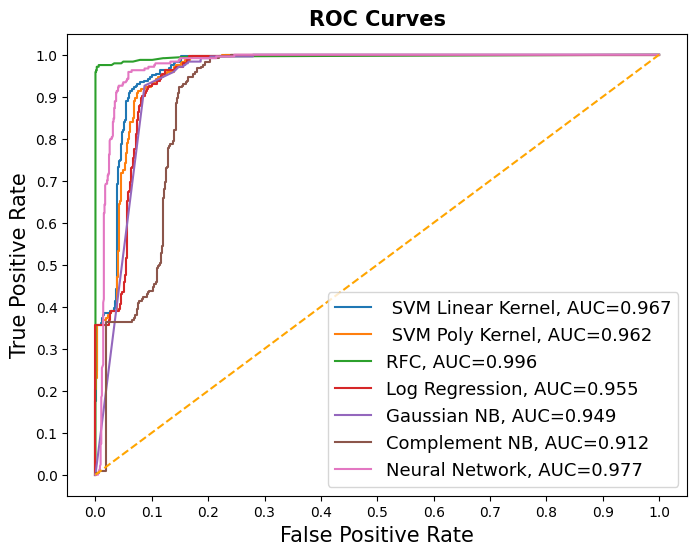

In [25]:
# 绘制ROC曲线
fig = plt.figure(figsize=(8, 6))


for result in results:
    plt.plot(result[0], result[1], label=result[2])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curves', fontweight='bold', fontsize=15)
plt.legend(prop={'size': 13}, loc='lower right')

plt.show()

In [ ]:
import joblib

# 假设 models 是一个字典，包含所有训练好的模型
for model_name, model in models.items():
    joblib.dump(model, f'D:/{model_name}_model.pkl')
# 保存神经网络模型
model.save('D:/neural_network_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# 加载 SVC 模型
svc_linear = joblib.load('D:/svc_linear_model.pkl')

# 加载随机森林模型
rfc_model = joblib.load('D:/random_forest_model.pkl')

# 加载逻辑回归模型
logreg_model = joblib.load('D:/logistic_regression_model.pkl')

# 加载高斯朴素贝叶斯模型
n_bayes = joblib.load('D:/gaussian_nb_model.pkl')

# 加载互补朴素贝叶斯模型
cn_bayes = joblib.load('D:/complement_nb_model.pkl')

# 加载神经网络模型
model = load_model('D:/neural_network_model.keras', compile=False)

# 重新编译模型
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


# 假设你有新的测试数据
new_x_test = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]])  # 示例数据
new_y_test = np.array([0])  # 示例标签
new_x_test_normalized = preprocessing.normalize(new_x_test)

# 使用归一化后的数据进行预测
svc_pred = svc_linear.predict(new_x_test_normalized)
rfc_pred = rfc_model.predict(new_x_test_normalized)
logreg_pred = logreg_model.predict(new_x_test_normalized)
gnb_pred = n_bayes.predict(new_x_test_normalized)
cnb_pred = cn_bayes.predict(new_x_test_normalized)
nn_pred = (model.predict(new_x_test_normalized) > 0.5).astype(int)

print("SVC Linear Predictions:", svc_pred)
print("Random Forest Predictions:", rfc_pred)
print("Logistic Regression Predictions:", logreg_pred)
print("Gaussian Naive Bayes Predictions:", gnb_pred)
print("Complement Naive Bayes Predictions:", cnb_pred)
print("Neural Network Predictions:", nn_pred)

In [ ]:
# models = {}
# models['SVC_linear_classifier'] = SVC_linear_classifier
# models['SVC_poly_classifier'] = SVC_poly_classifier
# models['rfc_model'] = rfc_model
# models['logreg_model'] = logreg_model
# models['n_bayes'] = n_bayes
# models['cn_bayes'] = cn_bayes
# models['neural_network'] = model

In [ ]:
# results = []
# models = {}

In [ ]:
# # 训练并评估线性核函数的SVC模型
# results.append(train_and_evaluate_svc(x_train, y_train, x_test, y_test, 'linear'))

# # 训练并评估多项式核函数的SVC模型
# results.append(train_and_evaluate_svc(x_train, y_train, x_test, y_test, 'poly'))

# # 训练并评估随机森林模型
# results.append(train_and_evaluate_random_forest(x_train, y_train, x_test, y_test))
# # 训练并评估逻辑回归模型
# results.append(train_and_evaluate_logistic_regression(x_train, y_train, x_test, y_test))

# # 训练并评估高斯朴素贝叶斯模型
# results.append(train_and_evaluate_gaussian_nb(x_train, y_train, x_test, y_test))

# # 训练并评估互补朴素贝叶斯模型
# results.append(train_and_evaluate_complement_nb(x_train, y_train, x_test, y_test))

# # 定义神经网络训练参数
# batch_size = 32
# epochs = 20

# # 训练并评估神经网络模型
# results.append(train_and_evaluate_neural_network(x_train, y_train, x_test, y_test, batch_size, epochs))

# # 绘制ROC曲线
# fig = plt.figure(figsize=(8, 6))


# for result in results:
#     plt.plot(result[0], result[1], label=result[2])
# plt.plot([0, 1], [0, 1], color='orange', linestyle='--')

# plt.xticks(np.arange(0.0, 1.1, step=0.1))
# plt.xlabel("False Positive Rate", fontsize=15)

# plt.yticks(np.arange(0.0, 1.1, step=0.1))
# plt.ylabel("True Positive Rate", fontsize=15)

# plt.title('ROC Curves', fontweight='bold', fontsize=15)
# plt.legend(prop={'size': 13}, loc='lower right')

# plt.show()

In [ ]:
# results = []
# models = {}
# # 训练并评估线性核函数的SVC模型
# a,b = train_and_evaluate_svc(x_train, y_train, x_test, y_test, 'linear')
# results.append(a)
# # models.append(b)
# # 训练并评估多项式核函数的SVC模型
# a,b = train_and_evaluate_svc(x_train, y_train, x_test, y_test, 'poly')
# results.append(a)
# # models.append(b)
# # 训练并评估随机森林模型
# a,b = train_and_evaluate_random_forest(x_train, y_train, x_test, y_test)
# results.append(a)
# # models.append(b)
# # 训练并评估逻辑回归模型
# a,b = train_and_evaluate_logistic_regression(x_train, y_train, x_test, y_test)
# results.append(a)
# # models.append(b)
# # 训练并评估高斯朴素贝叶斯模型
# a,b = train_and_evaluate_gaussian_nb(x_train, y_train, x_test, y_test)
# results.append(a)
# # models.append(b)
# # 训练并评估互补朴素贝叶斯模型
# a,b = train_and_evaluate_complement_nb(x_train, y_train, x_test, y_test)
# results.append(a)
# # models.append(b)
# # 定义神经网络训练参数
# batch_size = 32
# epochs = 20

# # 训练并评估神经网络模型
# a,b = train_and_evaluate_neural_network(x_train, y_train, x_test, y_test, batch_size, epochs)
# results.append(a)
# # models.append(b)
# # 绘制ROC曲线
# fig = plt.figure(figsize=(8, 6))


# for result in results:
#     plt.plot(result[0], result[1], label=result[2])
# plt.plot([0, 1], [0, 1], color='orange', linestyle='--')

# plt.xticks(np.arange(0.0, 1.1, step=0.1))
# plt.xlabel("False Positive Rate", fontsize=15)

# plt.yticks(np.arange(0.0, 1.1, step=0.1))
# plt.ylabel("True Positive Rate", fontsize=15)

# plt.title('ROC Curves', fontweight='bold', fontsize=15)
# plt.legend(prop={'size': 13}, loc='lower right')

# plt.show()